<!-- docusaurus_head_meta::start
---
title: Structured Outputs for Multi-Agent Systems
---
docusaurus_head_meta::end -->

<!--- @wandbcode{openai-structured-output} -->

# Structured Outputs for Multi-Agent Systems

OpenAI relased [Structured Outputs](https://openai.com/index/introducing-structured-outputs-in-the-api/) to enable users to ensure the model will always generate responses that adhere to your supplied JSON Schema without strongly worded prompts. With Structured Outputs, we don't need to validate or retry incorrectly formatted responses.

By using the new parameter `strict: true`, we are able to guarantee the response abides by a provided schema.

The use of structured outputs in a multi-agent system enhances communication by ensuring consistent, easily processed data between agents. It also improves safety by allowing explicit refusals and boosts performance by eliminating the need for retries or validations. This simplifies interactions and increases overall system efficiency.

This tutorial demonstrates how we can utilize structured outputs in multi-agent system and trace them with [Weave](https://weave-docs.wandb.ai/).

:::tip [Source](https://cookbook.openai.com/examples/structured_outputs_multi_agent)
This cookbook is based on [sample code from OpenAI's structured outputs](https://cookbook.openai.com/examples/structured_outputs_multi_agent), with some modifications added for improved visualization using Weave.
:::

## Installing the Dependencies

We need the following libraries for this tutorial:
- [OpenAI](https://openai.com/index/openai-api/) to create multi-agent system.
- [Weave](../../introduction.md) to track our LLM workflow and evaluate our prompting strategies.


In [ ]:
!pip install -qU openai weave wandb

In [ ]:
%%capture
# Temporary workaround to fix bug in openai:
# TypeError: Client.__init__() got an unexpected keyword argument 'proxies'
# See https://community.openai.com/t/error-with-openai-1-56-0-client-init-got-an-unexpected-keyword-argument-proxies/1040332/15
!pip install "httpx<0.28"

We set `WANDB_API_KEY` in our env so that we may easily login with wandb.login() (this should be given to the colab as a secret).

We set the project in W&B we want to log this into in `name_of_wandb_project`.

**NOTE**: `name_of_wandb_project` may also be in the format of `{team_name}/{project_name}` to specify a team to log the traces into.
We then fetch a weave client by calling weave.init()


Since we'll be using [OpenAI API](https://openai.com/index/openai-api/), we will also need an OpenAI API key. You can [sign up](https://platform.openai.com/signup) on the OpenAI platform to get your own API key. (this should be given to the colab as a secret too.)



In [ ]:
import base64
import json
import os
from io import BytesIO, StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
from google.colab import userdata
from openai import OpenAI

import weave

In [ ]:
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

wandb.login()
name_of_wandb_project = "multi-agent-structured-output"
weave.init(name_of_wandb_project)

client = OpenAI()
MODEL = "gpt-4o-2024-08-06"

## Agents set up

The use case we will tackle is a data analysis task.
Let's first set up our 4-agents system:

* Triaging agent: Decides which agent(s) to call
* Data pre-processing Agent: Prepares data for analysis - for example by cleaning it up
* Data Analysis Agent: Performs analysis on the data
* Data Visualization Agent: Visualizes the output of the analysis to extract insights
We will start by defining the system prompts for each of these agents.

In [ ]:
triaging_system_prompt = """You are a Triaging Agent. Your role is to assess the user's query and route it to the relevant agents. The agents available are:
- Data Processing Agent: Cleans, transforms, and aggregates data.
- Analysis Agent: Performs statistical, correlation, and regression analysis.
- Visualization Agent: Creates bar charts, line charts, and pie charts.

Use the send_query_to_agents tool to forward the user's query to the relevant agents. Also, use the speak_to_user tool to get more information from the user if needed."""

processing_system_prompt = """You are a Data Processing Agent. Your role is to clean, transform, and aggregate data using the following tools:
- clean_data
- transform_data
- aggregate_data"""

analysis_system_prompt = """You are an Analysis Agent. Your role is to perform statistical, correlation, and regression analysis using the following tools:
- stat_analysis
- correlation_analysis
- regression_analysis"""

visualization_system_prompt = """You are a Visualization Agent. Your role is to create bar charts, line charts, and pie charts using the following tools:
- create_bar_chart
- create_line_chart
- create_pie_chart"""

We will then define the tools for each agent.

Apart from the triaging agent, each agent will be equipped with tools specific to their role:

**Data pre-processing agent** : 1. Clean data, 2. Transform data, 3. Aggregate data

**Data analysis agent** : 1. Statistical analysis, 2. Correlation analysis, 3. Regression Analysis

**Data visualization agent** : 1. Create bar chart, 2. Create line chart, 3. Create pie chart


In [ ]:
triage_tools = [
    {
        "type": "function",
        "function": {
            "name": "send_query_to_agents",
            "description": "Sends the user query to relevant agents based on their capabilities.",
            "parameters": {
                "type": "object",
                "properties": {
                    "agents": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "An array of agent names to send the query to.",
                    },
                    "query": {
                        "type": "string",
                        "description": "The user query to send.",
                    },
                },
                "required": ["agents", "query"],
            },
        },
        "strict": True,
    }
]

preprocess_tools = [
    {
        "type": "function",
        "function": {
            "name": "clean_data",
            "description": "Cleans the provided data by removing duplicates and handling missing values.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to clean. Should be in a suitable format such as JSON or CSV.",
                    }
                },
                "required": ["data"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
    {
        "type": "function",
        "function": {
            "name": "transform_data",
            "description": "Transforms data based on specified rules.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data to transform. Should be in a suitable format such as JSON or CSV.",
                    },
                    "rules": {
                        "type": "string",
                        "description": "Transformation rules to apply, specified in a structured format.",
                    },
                },
                "required": ["data", "rules"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
    {
        "type": "function",
        "function": {
            "name": "aggregate_data",
            "description": "Aggregates data by specified columns and operations.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data to aggregate. Should be in a suitable format such as JSON or CSV.",
                    },
                    "group_by": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Columns to group by.",
                    },
                    "operations": {
                        "type": "string",
                        "description": "Aggregation operations to perform, specified in a structured format.",
                    },
                },
                "required": ["data", "group_by", "operations"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
]


analysis_tools = [
    {
        "type": "function",
        "function": {
            "name": "stat_analysis",
            "description": "Performs statistical analysis on the given dataset.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to analyze. Should be in a suitable format such as JSON or CSV.",
                    }
                },
                "required": ["data"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
    {
        "type": "function",
        "function": {
            "name": "correlation_analysis",
            "description": "Calculates correlation coefficients between variables in the dataset.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to analyze. Should be in a suitable format such as JSON or CSV.",
                    },
                    "variables": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "List of variables to calculate correlations for.",
                    },
                },
                "required": ["data", "variables"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
    {
        "type": "function",
        "function": {
            "name": "regression_analysis",
            "description": "Performs regression analysis on the dataset.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The dataset to analyze. Should be in a suitable format such as JSON or CSV.",
                    },
                    "dependent_var": {
                        "type": "string",
                        "description": "The dependent variable for regression.",
                    },
                    "independent_vars": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "List of independent variables.",
                    },
                },
                "required": ["data", "dependent_var", "independent_vars"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
]

visualization_tools = [
    {
        "type": "function",
        "function": {
            "name": "create_bar_chart",
            "description": "Creates a bar chart from the provided data.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data for the bar chart. Should be in a suitable format such as JSON or CSV.",
                    },
                    "x": {"type": "string", "description": "Column for the x-axis."},
                    "y": {"type": "string", "description": "Column for the y-axis."},
                },
                "required": ["data", "x", "y"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
    {
        "type": "function",
        "function": {
            "name": "create_line_chart",
            "description": "Creates a line chart from the provided data.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data for the line chart. Should be in a suitable format such as JSON or CSV.",
                    },
                    "x": {"type": "string", "description": "Column for the x-axis."},
                    "y": {"type": "string", "description": "Column for the y-axis."},
                },
                "required": ["data", "x", "y"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
    {
        "type": "function",
        "function": {
            "name": "create_pie_chart",
            "description": "Creates a pie chart from the provided data.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                        "type": "string",
                        "description": "The data for the pie chart. Should be in a suitable format such as JSON or CSV.",
                    },
                    "labels": {
                        "type": "string",
                        "description": "Column for the labels.",
                    },
                    "values": {
                        "type": "string",
                        "description": "Column for the values.",
                    },
                },
                "required": ["data", "labels", "values"],
                "additionalProperties": False,
            },
        },
        "strict": True,
    },
]

## Enable tracking of multi-agent using Weave

We need to write the code logic to:

* handle passing the user query to the multi-agent system
* handle the internal workings of the multi-agent system
* execute the tool calls

In [ ]:
# Example query

user_query = """
Below is some data. I want you to first remove the duplicates then analyze the statistics of the data as well as plot a line chart.

house_size (m3), house_price ($)
90, 100
80, 90
100, 120
90, 100
"""

From the user query, we can infer that the tools we would need to call are `clean_data`, `start_analysis` and `use_line_chart`.

We will begin by defining the execution function responsible for running tool calls.

By decorating Python functions with `@weave.op()`, we can log and debug language model inputs, outputs, and traces.

When creating a multi-agent system, many functions will appear, but it's sufficient to simply add `@weave.op()` on top of them.

In [ ]:
@weave.op()
def clean_data(data):
    data_io = StringIO(data)
    df = pd.read_csv(data_io, sep=",")
    df_deduplicated = df.drop_duplicates()
    return df_deduplicated


@weave.op()
def stat_analysis(data):
    data_io = StringIO(data)
    df = pd.read_csv(data_io, sep=",")
    return df.describe()


@weave.op()
def plot_line_chart(data):
    data_io = StringIO(data)
    df = pd.read_csv(data_io, sep=",")

    x = df.iloc[:, 0]
    y = df.iloc[:, 1]

    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    y_fit = polynomial(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, "o", label="Data Points")
    plt.plot(x, y_fit, "-", label="Best Fit Line")
    plt.title("Line Chart with Best Fit Line")
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.grid(True)

    # Save the plot to a BytesIO buffer before showing it
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    # Display the plot
    plt.show()

    # Encode the image in base64 for the data URL
    image_data = buf.getvalue()
    base64_encoded_data = base64.b64encode(image_data)
    base64_string = base64_encoded_data.decode("utf-8")
    data_url = f"data:image/png;base64,{base64_string}"

    return data_url


# Define the function to execute the tools
@weave.op()
def execute_tool(tool_calls, messages):
    for tool_call in tool_calls:
        tool_name = tool_call.function.name
        tool_arguments = json.loads(tool_call.function.arguments)

        if tool_name == "clean_data":
            # Simulate data cleaning
            cleaned_df = clean_data(tool_arguments["data"])
            cleaned_data = {"cleaned_data": cleaned_df.to_dict()}
            messages.append(
                {"role": "tool", "name": tool_name, "content": json.dumps(cleaned_data)}
            )
            print("Cleaned data: ", cleaned_df)
        elif tool_name == "transform_data":
            # Simulate data transformation
            transformed_data = {"transformed_data": "sample_transformed_data"}
            messages.append(
                {
                    "role": "tool",
                    "name": tool_name,
                    "content": json.dumps(transformed_data),
                }
            )
        elif tool_name == "aggregate_data":
            # Simulate data aggregation
            aggregated_data = {"aggregated_data": "sample_aggregated_data"}
            messages.append(
                {
                    "role": "tool",
                    "name": tool_name,
                    "content": json.dumps(aggregated_data),
                }
            )
        elif tool_name == "stat_analysis":
            # Simulate statistical analysis
            stats_df = stat_analysis(tool_arguments["data"])
            stats = {"stats": stats_df.to_dict()}
            messages.append(
                {"role": "tool", "name": tool_name, "content": json.dumps(stats)}
            )
            print("Statistical Analysis: ", stats_df)
        elif tool_name == "correlation_analysis":
            # Simulate correlation analysis
            correlations = {"correlations": "sample_correlations"}
            messages.append(
                {"role": "tool", "name": tool_name, "content": json.dumps(correlations)}
            )
        elif tool_name == "regression_analysis":
            # Simulate regression analysis
            regression_results = {"regression_results": "sample_regression_results"}
            messages.append(
                {
                    "role": "tool",
                    "name": tool_name,
                    "content": json.dumps(regression_results),
                }
            )
        elif tool_name == "create_bar_chart":
            # Simulate bar chart creation
            bar_chart = {"bar_chart": "sample_bar_chart"}
            messages.append(
                {"role": "tool", "name": tool_name, "content": json.dumps(bar_chart)}
            )
        elif tool_name == "create_line_chart":
            # Simulate line chart creation
            line_chart = {"line_chart": plot_line_chart(tool_arguments["data"])}
            messages.append(
                {"role": "tool", "name": tool_name, "content": json.dumps(line_chart)}
            )
        elif tool_name == "create_pie_chart":
            # Simulate pie chart creation
            pie_chart = {"pie_chart": "sample_pie_chart"}
            messages.append(
                {"role": "tool", "name": tool_name, "content": json.dumps(pie_chart)}
            )
    return messages

Next, we will create the tool handlers for each of the sub-agents. These have a unique prompt and tool set passed to the model. The output is then passed to an execution function which runs the tool calls.

In [ ]:
# Define the functions to handle each agent's processing
@weave.op()
def handle_data_processing_agent(query, conversation_messages):
    messages = [{"role": "system", "content": processing_system_prompt}]
    messages.append({"role": "user", "content": query})

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=preprocess_tools,
    )

    conversation_messages.append(
        [tool_call.function for tool_call in response.choices[0].message.tool_calls]
    )
    execute_tool(response.choices[0].message.tool_calls, conversation_messages)


@weave.op()
def handle_analysis_agent(query, conversation_messages):
    messages = [{"role": "system", "content": analysis_system_prompt}]
    messages.append({"role": "user", "content": query})

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=analysis_tools,
    )

    conversation_messages.append(
        [tool_call.function for tool_call in response.choices[0].message.tool_calls]
    )
    execute_tool(response.choices[0].message.tool_calls, conversation_messages)


@weave.op()
def handle_visualization_agent(query, conversation_messages):
    messages = [{"role": "system", "content": visualization_system_prompt}]
    messages.append({"role": "user", "content": query})

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=visualization_tools,
    )

    conversation_messages.append(
        [tool_call.function for tool_call in response.choices[0].message.tool_calls]
    )
    execute_tool(response.choices[0].message.tool_calls, conversation_messages)

Finally, we create the overarching tool to handle processing the user query. This function takes the user query, gets a response from the model and handles passing it to the other agents to execute.

In [ ]:
# Function to handle user input and triaging
@weave.op()
def handle_user_message(user_query, conversation_messages=[]):
    user_message = {"role": "user", "content": user_query}
    conversation_messages.append(user_message)

    messages = [{"role": "system", "content": triaging_system_prompt}]
    messages.extend(conversation_messages)

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        tools=triage_tools,
    )

    conversation_messages.append(
        [tool_call.function for tool_call in response.choices[0].message.tool_calls]
    )

    for tool_call in response.choices[0].message.tool_calls:
        if tool_call.function.name == "send_query_to_agents":
            agents = json.loads(tool_call.function.arguments)["agents"]
            query = json.loads(tool_call.function.arguments)["query"]
            for agent in agents:
                if agent == "Data Processing Agent":
                    handle_data_processing_agent(query, conversation_messages)
                elif agent == "Analysis Agent":
                    handle_analysis_agent(query, conversation_messages)
                elif agent == "Visualization Agent":
                    handle_visualization_agent(query, conversation_messages)

    outputs = extract_tool_contents(conversation_messages)

    return outputs


functions = [
    "clean_data",
    "transform_data",
    "stat_analysis",
    "aggregate_data",
    "correlation_analysis",
    "regression_analysis",
    "create_bar_chart",
    "create_line_chart",
    "create_pie_chart",
]


@weave.op()
def extract_tool_contents(data):
    contents = {}
    contents["all"] = data
    for element in data:
        if isinstance(element, dict):
            if element.get("role") == "tool" and element.get("name") in functions:
                name = element["name"]
                content_str = element["content"]
                try:
                    content_json = json.loads(content_str)
                    if "chart" not in element.get("name"):
                        contents[name] = [content_json]
                    else:
                        first_key = next(iter(content_json))
                        second_level = content_json[first_key]
                        if isinstance(second_level, dict):
                            second_key = next(iter(second_level))
                            contents[name] = second_level[second_key]
                        else:
                            contents[name] = second_level
                except json.JSONDecodeError:
                    print(f"Error decoding JSON for {name}")
                    contents[name] = None

    return contents

## Execute multi-agent systems and visualization in Weave

Finally, we execute the primary `handle_user_message` function using the user's input and observe the results.

In [ ]:
handle_user_message(user_query)

When we click on the URL for Weave, we can see that the execution is being traced as follows. On the Traces page, we can check the input and output. For clarity, screenshots of the results displayed when each output is clicked have been added to the diagram. Weave provides integration with OpenAI's API, which allows costs to be automatically calculated. So, we can confirm cost and latency are also displayed on the far right.
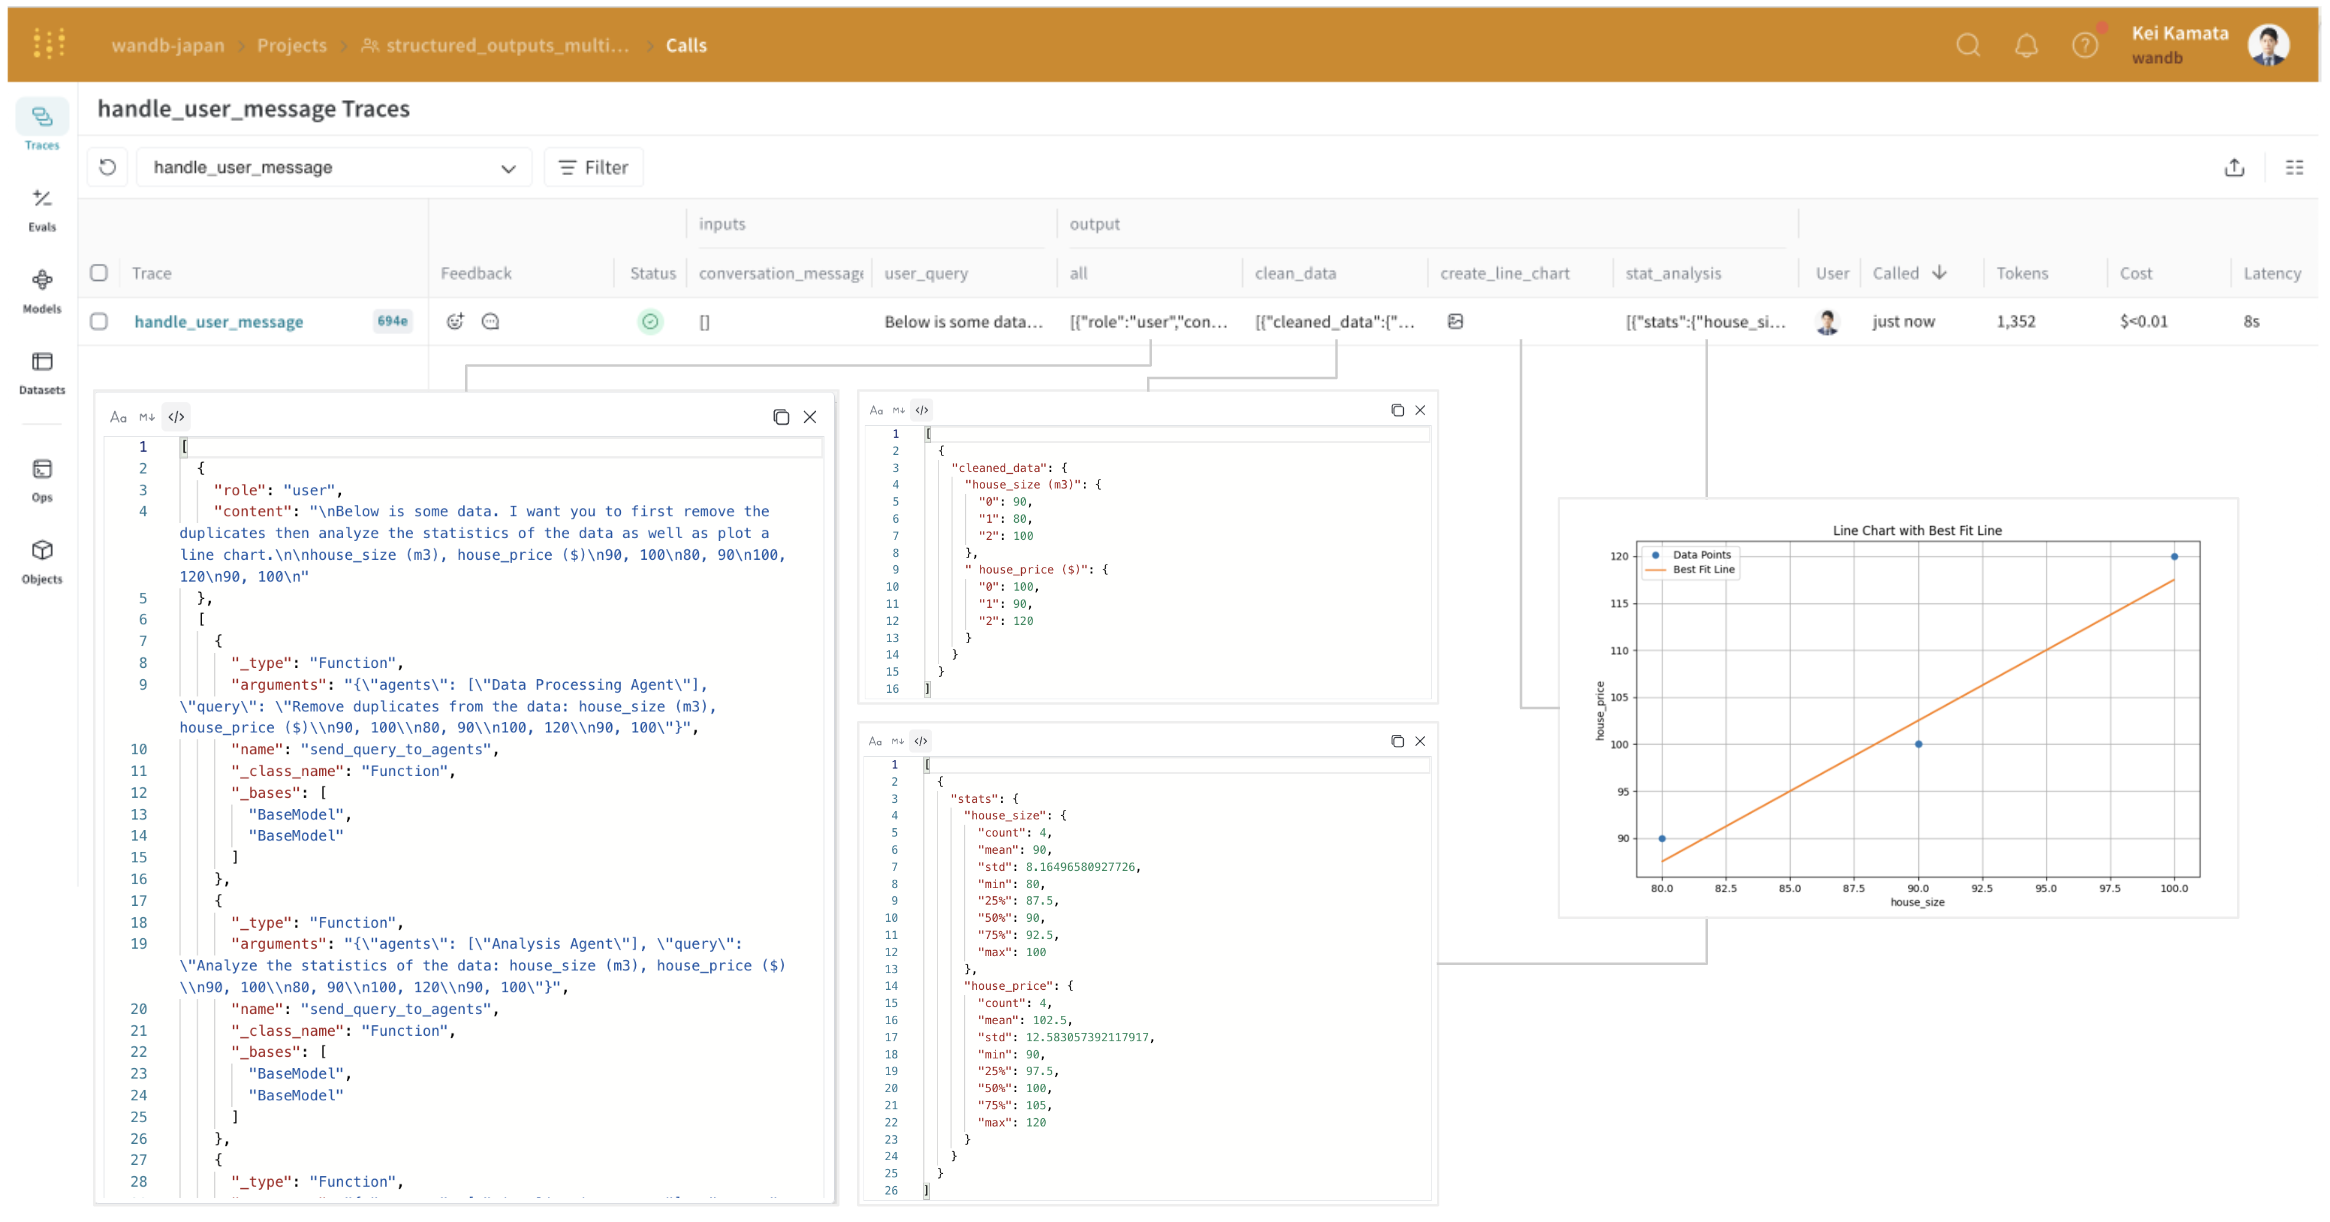




By clicking on a line, we can see the intermediate processes that were executed within the multi-agent system. For example, by looking at the input and output of the `analysis_agent`, we can see that it is in a structured output format. OpenAI's structured output facilitates collaboration between agents, but as the system becomes more complex, it becomes harder to grasp the format in which these interactions are taking place. Using Weave allows us to understand these intermediate processes and their inputs and outputs as if we were holding them in your hand.

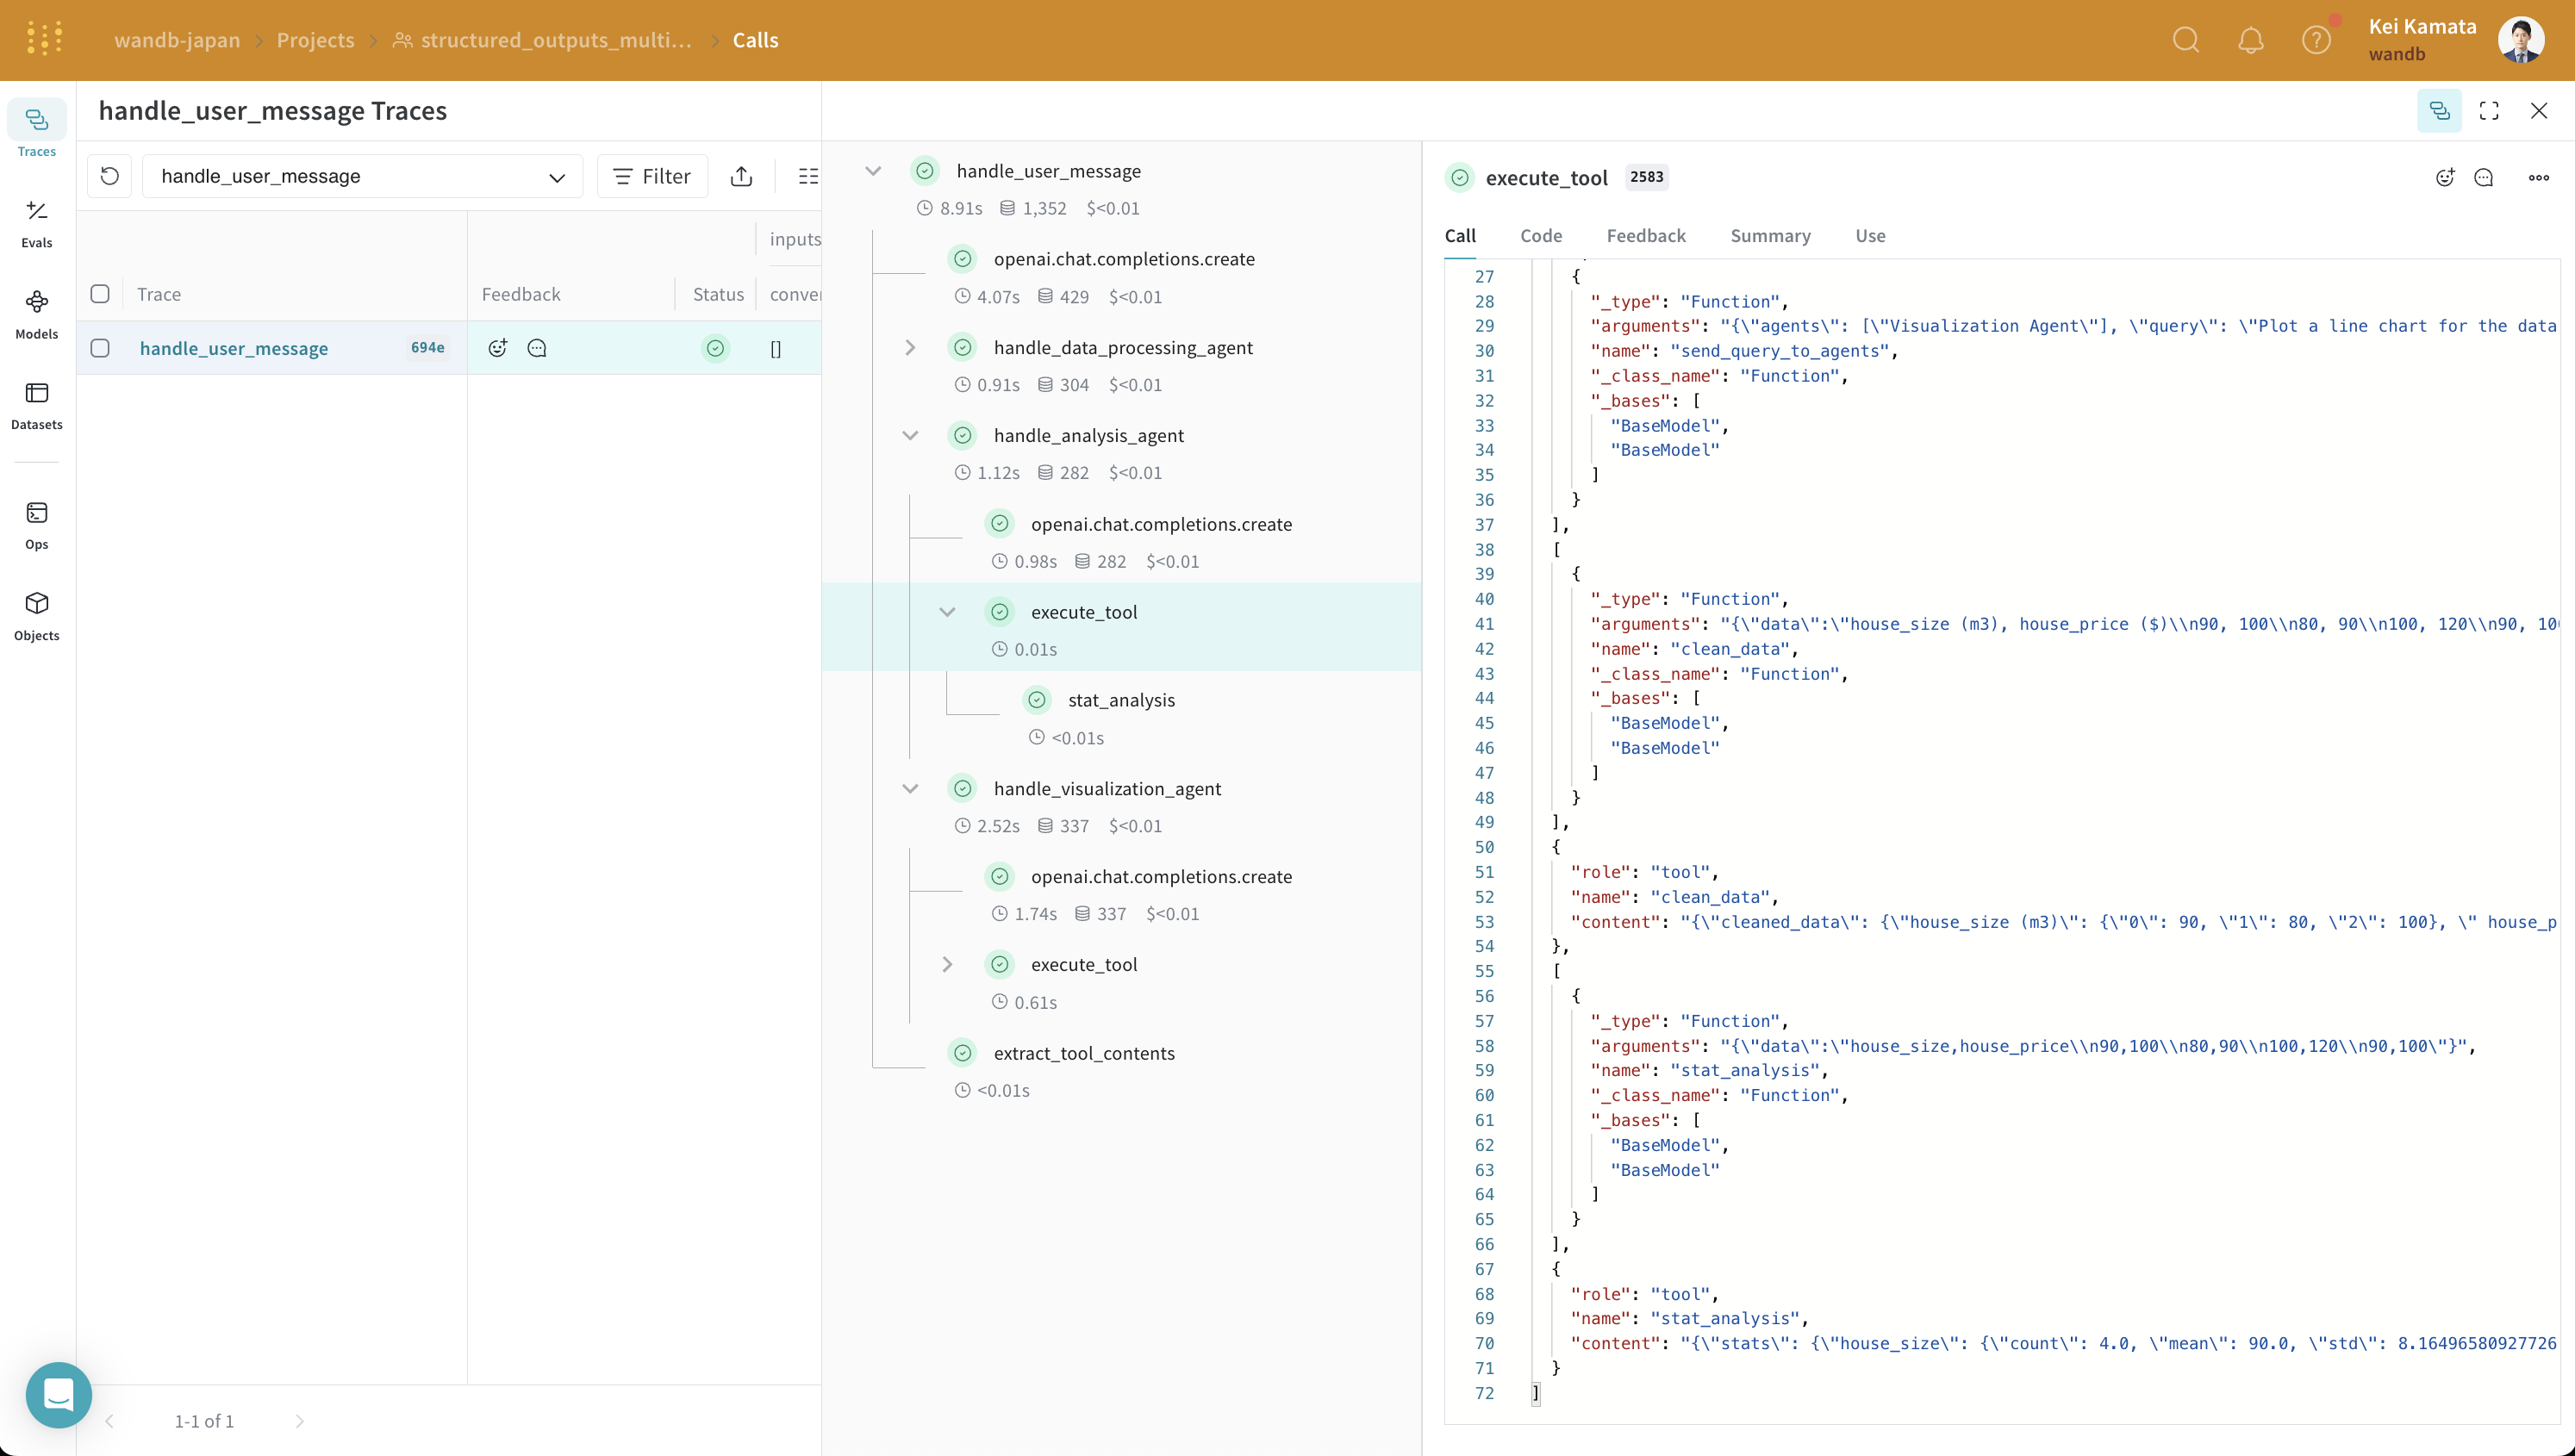

Please take a closer look at how tracing is handled in Weave!

## Conclusion
In this tutorial, we learned how to conveniently develop a multi-agent system using structured output and Weave, provided by OpenAI for tracking inputs, final outputs, and intermediate output formats.